In [2]:
import SimPEG as simpeg
import simpegMT as simpegmt
import numpy as np, os
import matplotlib.pyplot as plt


In [3]:
# Frequency
nFreq = 31
freqs = np.logspace(3,-3,nFreq)
# Set mesh parameters
ct = 10
air = simpeg.Utils.meshTensor([(ct,25,1.3)])
core = np.concatenate( (  np.kron(simpeg.Utils.meshTensor([(ct,5,-1.2)]),np.ones((3,))) , simpeg.Utils.meshTensor([(ct,5)]) ) )
bot = simpeg.Utils.meshTensor([(core[0],25,-1.3)])
x0 = -np.array([np.sum(np.concatenate((core,bot)))])
# Make the model
m1d = simpeg.Mesh.TensorMesh([np.concatenate((bot,core,air))], x0=x0)
# Setup model varibles
active = m1d.vectorCCx<0.
layer1 = (m1d.vectorCCx<-200.) & (m1d.vectorCCx>=-600.)
layer2 = (m1d.vectorCCx<-2000.) & (m1d.vectorCCx>=-4000.)
# Set the conductivity values
sig_half = 2e-3
sig_air = 1e-8
sig_layer1 = 1
sig_layer2 = .1
# Make the true model
sigma_true = np.ones(m1d.nCx)*sig_air
sigma_true[active] = sig_half
sigma_true[layer1] = sig_layer1
sigma_true[layer2] = sig_layer2
# Extract the model 
m_true = np.log(sigma_true[active])
# Make the background model
sigma_0 = np.ones(m1d.nCx)*sig_air
sigma_0[active] = sig_half
m_0 = np.log(sigma_0[active])


# Set the mapping# Set the mapping
actMap = simpeg.Maps.ActiveCells(m1d, active, np.log(1e-8), nC=m1d.nCx)
mappingExpAct = simpeg.Maps.ExpMap(m1d) * actMap

In [4]:
## Setup the layout of the survey, set the sources and the connected receivers

# Receivers 
rxList = []
for rxType in ['z1dr','z1di']:
    rxList.append(simpegmt.SurveyMT.RxMT(simpeg.mkvc(np.array([0.0]),2).T,rxType))
# Source list
srcList =[]
for freq in freqs:
        srcList.append(simpegmt.SurveyMT.srcMT_polxy_1Dprimary(rxList,freq))
# Make the survey
survey = simpegmt.SurveyMT.SurveyMT(srcList)
survey.mtrue = m_true
# Set the problem
problem = simpegmt.ProblemMT1D.eForm_psField(m1d,sigmaPrimary=sigma_0,mapping=mappingExpAct)
from pymatsolver import MumpsSolver
problem.solver = MumpsSolver
problem.pair(survey)

In [5]:
## Forward model observed data 
# Project the data
d_true = survey.dpred(m_true)
survey.dtrue = d_true
# Add noise to the true data
std = 0.05 # 5% std
noise = std*abs(survey.dtrue)*np.random.randn(*survey.dtrue.shape)
# Assign the dobs
survey.dobs = survey.dtrue + noise
survey.std = survey.dobs*0 + std
# Assign the data weight
survey.Wd = 1/(abs(survey.dobs)*std)

In [21]:
modList = []
modFiles = glob('*52.npy')
modFiles.sort()
for f in modFiles:
    modList.append(np.load(f))

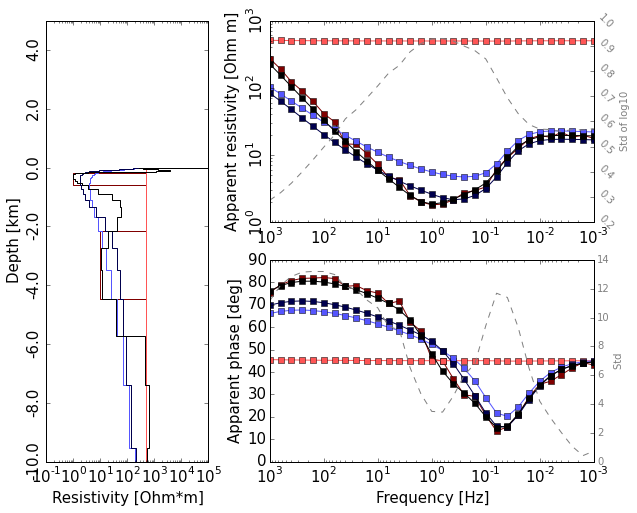

In [22]:
simpegmt.Utils.dataUtils.plotMT1DModelData(problem,[m_0,modList[10],modList[15],modList[24]])
plt.show()

ERROR: No traceback has been produced, nothing to debug.


In [18]:
len(modList)

25